# Using KNN to predict car prices with multivariate and hyperparameter tuning

Dataset contains: the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. 

Unit of Analysis: each car

Target Variable: price 

Further information about the dataset is available from: 
https://archive.ics.uci.edu/ml/datasets/automobile



# Data Cleaning

In [12]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 99

column_names =  ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 
        'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=column_names)

We select all numeric columns, including dytype = object that are numeric, to use KNN


In [13]:
cols_numeric = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 
                'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[cols_numeric]

numeric_cars = numeric_cars.replace('?',np.nan)
numeric_cars.head() 
numeric_cars.dtypes
numeric_cars = numeric_cars.astype(float)

drop all Null values for price since price is target the variable 

In [14]:
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()


normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

replace all other null observations with column means 


In [15]:
numeric_cars = numeric_cars.fillna(numeric_cars.mean())
numeric_cars.isnull().sum()


normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

 Normalize scaling. 
 
It is interesting to consider the affects of normalizing vs. standardizing data on model performance: KNNs can perform better with normalization: https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

There are two ways to normalize data that yield identical results.  

1) using sklearn 


In [ ]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# numeric_cars = min_max_scaler.fit_transform(numeric_cars)

2) Using Formulas

In [16]:
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

# Univariate KNN Model 

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
def knn_train_test(train, target, df):
    np.random.seed(1)
    random_index = np.random.permutation(df.index)
    df_shuffled = df.reindex(random_index)
    # We use the 75/25 split, given that the data is not large, a 50/50 split may be worth considering 
    last_train_row = int(len(df_shuffled) * 3/4)
    train_df = df_shuffled.iloc[0:last_train_row]
    test_df = df_shuffled.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9,11,13,15]
    k_rmses = {}
    for k in k_values :
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train]],train_df[target])
        pred_var = knn.predict(test_df[[train]])
    
        mse = mean_squared_error(test_df[target], pred_var)
        rmse = np.sqrt(mse)
        k_rmses[k] = rmse
    return k_rmses

rmse_results = {}

train_col = numeric_cars.columns.drop('price')

for i in train_col:
    rmse = knn_train_test(i, 'price', numeric_cars)
    rmse_results[i] = rmse

rmse_results


{'normalized-losses': {1: 6499.876425672999,
  3: 6373.107123484384,
  5: 6231.311123986794,
  7: 6434.331952881507,
  9: 6534.518371010953,
  11: 6666.449407029468,
  13: 6888.501966847079,
  15: 7152.106679518069},
 'wheel-base': {1: 2740.62572288541,
  3: 3417.1446705321687,
  5: 4161.947971897813,
  7: 4572.080496976003,
  9: 4488.496411259577,
  11: 4525.007727297465,
  13: 4563.079036660858,
  15: 4509.627786021055},
 'length': {1: 5297.150036557764,
  3: 5507.625440160827,
  5: 5416.294063685402,
  7: 5030.583828449936,
  9: 4407.827047652169,
  11: 4469.555360625737,
  13: 4390.3912867633535,
  15: 4196.265468329806},
 'width': {1: 2791.733012966368,
  3: 4083.105499312811,
  5: 3917.2276702270137,
  7: 3722.033525295731,
  9: 3665.167444110463,
  11: 3632.658816929262,
  13: 3571.921138696896,
  15: 3671.6792186435264},
 'height': {1: 8302.179086735921,
  3: 7159.369749588925,
  5: 6666.667677627373,
  7: 6570.390279532118,
  9: 6484.278955313533,
  11: 6268.373445861512,
  13

### Plot k-value vs. RMSE 


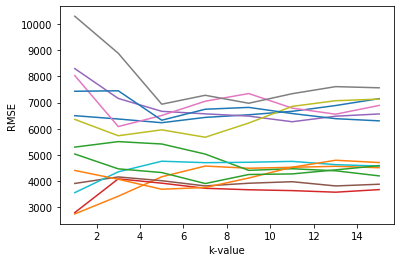

In [18]:
import matplotlib.pyplot as plt

for k,v in rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x,y)
    plt.xlabel('k-value')
    plt.ylabel('RMSE')

# Multivariate model with hyperparameter tuning 

### We first compute average RMSE across different k for each feature 

In [19]:
feature_avg_rmse = {}
for k,v in rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_series_avg_rmse.index


width                3631.940791
curb-weight          3932.687654
wheel-base           4122.251228
city-mpg             4256.018153
highway-mpg          4407.544922
horsepower           4503.776380
length               4839.461567
compression-rate     6375.652499
normalized-losses    6597.525381
peak-rpm             6755.915332
height               6812.249410
bore                 6908.322001
stroke               7863.897105
dtype: float64


### We define the KNN function with hyperparameter tuning

In [21]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # 75/25 split 
    last_train_row = int(len(rand_df) * 3/4)
    
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 25)]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k where k ranges from 1 - 25 
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Predict
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

### We find the best 2,3,4,5,6,7 features based on "sorted features" calculated above. 

In [22]:
k_rmse_results = {}

for nr_best_feats in range(2,7):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

{'2 best features': {1: 3986.111521122249,
  2: 3826.8074865631384,
  3: 4038.9323383229885,
  4: 3381.1053836276797,
  5: 3291.0824443769666,
  6: 3181.1413771363536,
  7: 3070.901670980223,
  8: 2990.722543945726,
  9: 2888.7276369442325,
  10: 2762.9700871614627,
  11: 2864.052793788353,
  12: 2985.447915630826,
  13: 3077.4697141880997,
  14: 3137.1097962375275,
  15: 3216.3857732345778,
  16: 3300.2905392261696,
  17: 3397.0376277393643,
  18: 3499.673131103864,
  19: 3583.7017582154353,
  20: 3610.384366602515,
  21: 3532.6347467595224,
  22: 3604.895036906162,
  23: 3668.520748027148,
  24: 3730.4892552821902},
 '3 best features': {1: 2635.050153929805,
  2: 2609.0845306803103,
  3: 3211.872811032275,
  4: 3378.7666751490906,
  5: 3120.28913165079,
  6: 3009.9071024286686,
  7: 2864.046061979111,
  8: 2635.12146257986,
  9: 2822.4020037774803,
  10: 2775.2161095146816,
  11: 2972.303824796519,
  12: 3079.4855745730106,
  13: 3193.4622944076636,
  14: 3304.5228976408093,
  15: 33

### K-value vs. RMSE graph for k value from 1-25 
### Different lines are different # of features 

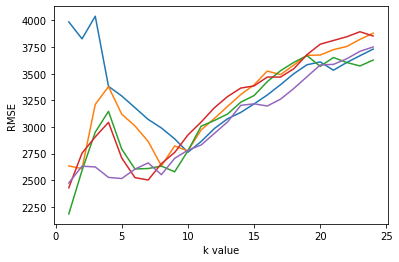

In [23]:

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    
